### Advanced Notebook: Requesting the catalog client
In Terrascope, you can request the catalog client to retrieve the various products that are stored. Below we start with importing the necessary packages for putting the requests, as well as the other more standard packages.


In [1]:
from catalogclient import catalog                         # to interrogate the catalog
import datetime as dt                                     # date and time functions  
import re                                                 # to parse strings
import os                                                 # operating system functions
from xml.etree import ElementTree as ET                   # XML parsing
import rasterio                                           # raster files 
import matplotlib.pyplot as mplot                         # plotting functions
from mpl_toolkits.axes_grid1 import make_axes_locatable   # more plotting functions
import seaborn as sns                                     # extended plotting possibilities wrt matplotlib
import glob                                               # alternative to using os, file/directory searches etc.
import numpy as np                                        # standard Python numpy
import sys                                                # standard Python system package


### Product types

#### Terrascope Sentinel Product types
First, we have a look at the different Sentinel Product Types available in the catalog.

In [2]:
cat=catalog.Catalog()
listOfProducttypes = cat.get_producttypes()

#there are many products in the list, so we want to select just the ones related to Sentinel. These have a 'CGS' prefix
listOfTerrascopeSentinelProducttypes = list(filter(lambda f: 'CGS' in f,listOfProducttypes))
listOfTerrascopeSentinelProducttypes

['CGS_S2_FAPAR',
 'CGS_S2_FAPAR_10M',
 'CGS_S2_FAPAR_20M',
 'CGS_S2_NDVI',
 'CGS_S2_NDVI_10M',
 'CGS_S2_LAI',
 'CGS_S2_LAI_10M',
 'CGS_S2_LAI_20M',
 'CGS_S2_FCOVER',
 'CGS_S2_FCOVER_10M',
 'CGS_S2_FCOVER_20M',
 'CGS_S2_RADIOMETRY',
 'CGS_S2_RADIOMETRY_10M',
 'CGS_S2_RADIOMETRY_20M',
 'CGS_S2_RADIOMETRY_60M',
 'CGS_S1_GRD_SIGMA0_L1']

S1 and S2 relate to the Sentinel satellites; the Sentinel-2 products are also split up per resolution. This is not just a change in spatial resolution:
* the 10 m resolution FAPAR, LAI and FCOVER indices use just the 10m band information 
* the 20 m resolution FAPAR, LAI and FCOVER indices use 10 m <b>and</b> 20 m band information

The S2 products that have no resolution suffix are legacy products that will be discontinued.

#### Looking for Terrascope PROBA-V product types
PROBA-V monitors the Earth's vegetation every day at 100 m (center camera only), 300 m, and 1 km resolution, with daily coverage poleward of 35$^o$ latitude.

In [3]:
listOfTerrascopePROBAVProducttypes = list(filter(lambda f: 'PROBAV' in f,listOfProducttypes))
listOfTerrascopePROBAVProducttypes

['PROBAV_L3_S1_TOC_1KM',
 'PROBAV_L3_S1_TOC_333M',
 'PROBAV_L3_S10_TOC_333M',
 'PROBAV_L3_S5_TOC_100M',
 'PROBAV_L3_S1_TOC_100M',
 'PROBAV_L3_S10_TOC_1KM',
 'PROBAV_L3_S1_TOA_1KM',
 'PROBAV_L3_S1_TOA_333M',
 'PROBAV_L3_S5_TOA_100M',
 'PROBAV_L3_S1_TOA_100M',
 'PROBAV_L1C',
 'PROBAV_L2A_1KM',
 'PROBAV_L2A_333M',
 'PROBAV_L2A_100M']

* Level 1 data (L1C) are individual Top-of-Atmosphere (TOA) unprojected segments 
* Level 2 data (L2A) are individual Top-of-Atmosphere projected segments at different resolutions (100 m, 300 m and 1 km)
* Level 3 data (L3) are 
    * composites (collection of segments, covering the Earth)
    * using 1 (S1) , 5 (100 m) or 10 days (300 m and 1 km) of observation
    * Top-of-Atmosphere or Top-of-Canopy (TOC, corrected for the atmospheric reflectance/absorption contribution)

#### Looking for SPOT-VEGETATION product types
The same as for PROBA-V can be done for the SPOT-VGT products.

In [4]:
listOfTerrascopeSPOTVGTProducttypes = list(filter(lambda f: 'SPOTVEGETATION' in f,listOfProducttypes))
listOfTerrascopeSPOTVGTProducttypes

['SPOTVEGETATION_L3_S1', 'SPOTVEGETATION_L3_S10']

So, here we have only L3 data: composites at 1 km resolution with comporising periods of 1 or 10 days.

### Products

#### Sentinel products
Below the catalog is requested to provide a list of the number of products available and over which time period.

In [5]:
for pt in listOfTerrascopeSentinelProducttypes:
    listOfTimes = cat.get_times(pt) 
    NumberofAcquisitions = len(listOfTimes)
    
    if NumberofAcquisitions > 0 :
        print('{}: {} products from {} to {}'.format(pt,NumberofAcquisitions, min(listOfTimes),max(listOfTimes)))
    else:
        print('{}: {} products'.format(pt,NumberofAcquisitions))
    


CGS_S2_FAPAR: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_FAPAR_10M: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_FAPAR_20M: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_NDVI: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_NDVI_10M: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_LAI: 1819 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_LAI_10M: 1819 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_LAI_20M: 1819 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_FCOVER: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_FCOVER_10M: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_FCOVER_20M: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_RADIOMETRY: 1820 products from 2015-07-06 10:53:51 to 2019-04-23 03:18:30
CGS_S2_RADIOMETRY_10M: 1820 products from 2015-07-06 10:53:5

#### PROBA-V products
Similar to the list provided for Sentinel, the number of PROBA-V products is requested.

In [6]:
for pt in listOfTerrascopePROBAVProducttypes:
    listOfTimes = cat.get_times(pt) 
    NumberofAcquisitions = len(listOfTimes)
    
    if NumberofAcquisitions > 0 :
        print('{}: {} products from {} to {}'.format(pt,NumberofAcquisitions, min(listOfTimes),max(listOfTimes)))
    else:
        print('{}: {} products'.format(pt,NumberofAcquisitions))
    

PROBAV_L3_S1_TOC_1KM: 1962 products from 2013-10-15 00:00:00 to 2019-03-03 00:00:00
PROBAV_L3_S1_TOC_333M: 1962 products from 2013-10-15 00:00:00 to 2019-03-03 00:00:00
PROBAV_L3_S10_TOC_333M: 194 products from 2013-10-11 00:00:00 to 2019-02-21 00:00:00
PROBAV_L3_S5_TOC_100M: 358 products from 2014-03-11 00:00:00 to 2019-02-26 00:00:00
PROBAV_L3_S1_TOC_100M: 1814 products from 2014-03-12 00:00:00 to 2019-03-03 00:00:00
PROBAV_L3_S10_TOC_1KM: 194 products from 2013-10-11 00:00:00 to 2019-02-21 00:00:00
PROBAV_L3_S1_TOA_1KM: 1962 products from 2013-10-15 00:00:00 to 2019-03-03 00:00:00
PROBAV_L3_S1_TOA_333M: 1962 products from 2013-10-15 00:00:00 to 2019-03-03 00:00:00
PROBAV_L3_S5_TOA_100M: 358 products from 2014-03-11 00:00:00 to 2019-02-26 00:00:00
PROBAV_L3_S1_TOA_100M: 1813 products from 2014-03-12 00:00:00 to 2019-03-03 00:00:00
PROBAV_L1C: 167746 products from 2013-10-15 00:25:20 to 2019-03-04 06:40:45
PROBAV_L2A_1KM: 161651 products from 2013-10-15 00:25:20 to 2019-03-04 06:40:45

#### SPOT-VEGETATION products

In [6]:
for pt in listOfTerrascopeSPOTVGTProducttypes:
    listOfTimes = cat.get_times(pt) 
    NumberofAcquisitions = len(listOfTimes)
    
    if NumberofAcquisitions > 0 :
        print('{}: {} products from {} to {}'.format(pt,NumberofAcquisitions, min(listOfTimes),max(listOfTimes)))
    else:
        print('{}: {} products'.format(pt,NumberofAcquisitions))

SPOTVEGETATION_L3_S1: 5901 products from 1998-04-01 00:00:00 to 2014-06-02 00:00:00
SPOTVEGETATION_L3_S10: 583 products from 1998-04-01 00:00:00 to 2014-06-01 00:00:00


#### Products in a selected area, within a predefined time window
To narrow down, below we provide a list of Sentinel products for a pre-defined time window over a selected area.
In this case, we want to select the GEOTiff fAPAR data for 1 - 5 July 2018 for the region 51 - 52$^o$N, 4 - 5$^o$E.

In [7]:
productName = 'CGS_S2_FAPAR_10M' # choose any product type in the lists we made earlier
startDate = dt.date(2018,7,1)
endDate = dt.date(2018,7,5)
minLatitude = 51 #in decimal degrees, positive for North
maxLatitude = 52
minLongitude = 4 #in decimal degrees, positive for East
maxLongitude = 5

#get the list of products
listOfProducts = cat.get_products (productName, 
                            fileformat='GEOTIFF', 
                            startdate=startDate, 
                            enddate=endDate, 
                            min_lon=minLongitude, 
                            max_lon=maxLongitude, 
                            min_lat=minLatitude, 
                            max_lat=maxLatitude)


nbands = 0
productList=[]

#loop over products
for p in listOfProducts:

    productelements=re.split("_",str(p))  
    nbands=nbands + len(p.bands())
    
    #loop over bands
    for b in p.bands():
        productdetails=[]
        productdetails.append(productelements[2])  # product name
        productdetails.append(productelements[3])  # resolution
        productdetails.append(productelements[-1]) # datetime
        productdetails.append(p.file(b)[5:]) # file path
       
        folders=re.split('/',p.file(b)[5:]) #this contains all subsequent folders + the actual filename
        items=re.split('_',folders[-1:][0])
        
        productdetails.append(items[2]) # UTM tile id
        productdetails.append(items[3]) # file content
        productList.append(productdetails)

#once productList is completed, print the results
print ('Tile  Date       Time     Res Product')
print ('----- ---------- -------- --- -------')
for p in productList:
    print (p[4], p[2], p[1], p[0], p[5])

Tile  Date       Time     Res Product
----- ---------- -------- --- -------
31UFT 2018-07-02 10:40:21 10M FAPAR SHADOWMASK
31UFT 2018-07-02 10:40:21 10M FAPAR SCENECLASSIFICATION
31UFT 2018-07-02 10:40:21 10M FAPAR CLOUDMASK
31UFT 2018-07-02 10:40:21 10M FAPAR FAPAR
31UET 2018-07-05 10:54:27 10M FAPAR SHADOWMASK
31UET 2018-07-05 10:54:27 10M FAPAR CLOUDMASK
31UET 2018-07-05 10:54:27 10M FAPAR SCENECLASSIFICATION
31UET 2018-07-05 10:54:27 10M FAPAR FAPAR
31UFS 2018-07-05 10:54:27 10M FAPAR FAPAR
31UFS 2018-07-05 10:54:27 10M FAPAR CLOUDMASK
31UFS 2018-07-05 10:54:27 10M FAPAR SHADOWMASK
31UFS 2018-07-05 10:54:27 10M FAPAR SCENECLASSIFICATION
31UES 2018-07-02 10:40:21 10M FAPAR CLOUDMASK
31UES 2018-07-02 10:40:21 10M FAPAR SCENECLASSIFICATION
31UES 2018-07-02 10:40:21 10M FAPAR SHADOWMASK
31UES 2018-07-02 10:40:21 10M FAPAR FAPAR
31UES 2018-07-03 10:59:38 10M FAPAR SCENECLASSIFICATION
31UES 2018-07-03 10:59:38 10M FAPAR FAPAR
31UES 2018-07-03 10:59:38 10M FAPAR SHADOWMASK
31UES 2018-07-0

To filter out the proper FAPAR files:

In [8]:
FAPARFiles=[]
for p in productList:
    if p[5]=='FAPAR':
        FAPARFiles.append(p)
        print(p)

['FAPAR', '10M', '2018-07-02 10:40:21', '/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/02/S2B_20180702T104019Z_31UFT_CGS_V102_000/S2B_20180702T104019Z_31UFT_FAPAR_V102/10M/S2B_20180702T104019Z_31UFT_FAPAR_10M_V102.tif', '31UFT', 'FAPAR']
['FAPAR', '10M', '2018-07-05 10:54:27', '/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/05/S2B_20180705T105029Z_31UET_CGS_V102_000/S2B_20180705T105029Z_31UET_FAPAR_V102/10M/S2B_20180705T105029Z_31UET_FAPAR_10M_V102.tif', '31UET', 'FAPAR']
['FAPAR', '10M', '2018-07-05 10:54:27', '/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/05/S2B_20180705T105029Z_31UFS_CGS_V102_000/S2B_20180705T105029Z_31UFS_FAPAR_V102/10M/S2B_20180705T105029Z_31UFS_FAPAR_10M_V102.tif', '31UFS', 'FAPAR']
['FAPAR', '10M', '2018-07-02 10:40:21', '/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/02/S2B_20180702T104019Z_31UES_CGS_V102_000/S2B_20180702T104019Z_31UES_FAPAR_V102/10M/S2B_20180702T104019Z_31UES_FAPAR_10M_V102.tif', '31UES', 'FAPAR']
['FAPAR', '10M', '2018-07-03 10:59:38', '/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018

Notice that the date and time indicated in the filename is **not the same as the date and time given by the product**. 
The latter is retrieved from the metadata provided by ESA, the former is defined by ESA. It is yet unknown why these times differ.

Let's open one of the files.

Once the data are red, we can convert them to physical values and plot the results. 
Also here, we do not yet read the conversion factors from the metadata, but use the hard coded value. 
Physical values > 1 are finally set to NaN (non-clear pixels).

In [9]:
f_fapar = FAPARFiles[2][3]
print(f_fapar)

with rasterio.open(f_fapar, 'r') as data:
    d_fapar=data.read(1).astype('uint8') #the FAPAR values are stored as byte data
  

/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/05/S2B_20180705T105029Z_31UFS_CGS_V102_000/S2B_20180705T105029Z_31UFS_FAPAR_V102/10M/S2B_20180705T105029Z_31UFS_FAPAR_10M_V102.tif


0.0 0.975


Text(0.5,1,'FAPAR tile 31UFS 2018-07-05 10:54:27\n non-clear pixels are white')

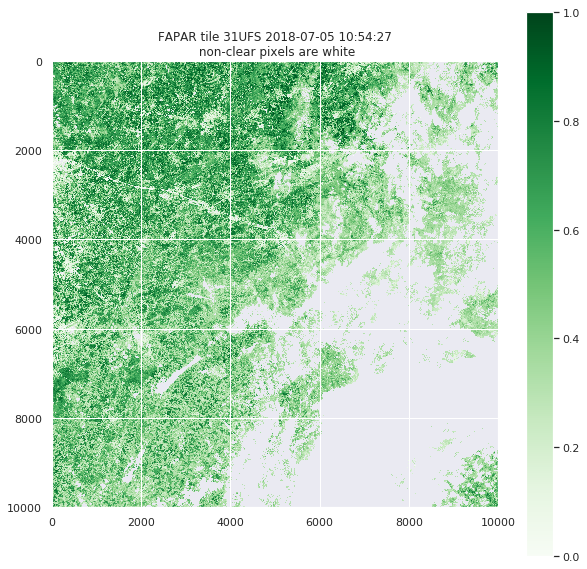

In [10]:
#set the seaborn plotting environment
sns.set()

#Take a subset, change these values if necessary
sub = np.array([0, 10000])

#Set NoData --> NaN, convert DN --> PV: for now use hard coded value
fapar_sub = d_fapar[sub[0]:sub[1],sub[0]:sub[1]]

fapar_sub[fapar_sub == 255] = -1
fapar_sub = fapar_sub * 0.005
fapar_sub[fapar_sub > 1.] = np.nan
print(np.nanmin(fapar_sub), np.nanmax(fapar_sub))

#create map plots for the RED and NIR and resulting NDVI, use subplots
mplot.figure(figsize=(10,10))
mplot.subplot(111) # we only want to plot one subplot

#show the FAPAR values
mplot.imshow(fapar_sub, cmap='Greens', vmin=0., vmax=1.0)
mplot.colorbar()

#there are many colormaps that you can use. See here: https://matplotlib.org/examples/color/colormaps_reference.html
mplot.title('FAPAR tile ' + FAPARFiles[2][4] + ' ' + FAPARFiles[2][2] + '\n non-clear pixels are white')

Now, let's do some processing. 
1. we will look for the raw 10 m Sentinel-2 bands 
2. then we load the RED (B03) and NIR (B08) bands to calculate the NDVI
3. and we show the results

In [11]:
#settings: product name, start and end date, and RoI
productName = 'CGS_S2_RADIOMETRY_10M' 
startDate = dt.date(2018,5,6)
endDate = dt.date(2018,5,7)
minLatitude = 51 
maxLatitude = 52
minLongitude = 4 
maxLongitude = 5

#catalog client request
listOfProducts = cat.get_products (productName, 
                            fileformat='GEOTIFF', 
                            startdate=startDate, 
                            enddate=endDate, 
                            min_lon=minLongitude, 
                            max_lon=maxLongitude, 
                            min_lat=minLatitude, 
                            max_lat=maxLatitude)

nbands = 0
productList=[]

#append to the product list
for p in listOfProducts:

    productelements=re.split("_",str(p))  
    nbands=nbands + len(p.bands())
    
    for b in p.bands():
        productdetails=[]
        print(productelements)
        productdetails.append(productelements[2])  # 0 product name 
        productdetails.append(productelements[3])  # 1 resolution
        productdetails.append(productelements[-1]) # 2 datetime
        productdetails.append(p.file(b)[5:]) # 3 filepath
       
        folders=re.split('/',p.file(b)[5:]) #this contains all subsequent folders + the actual filename
        filepath='/'
        for s in range(1,len(folders)-1):
            filepath = filepath + folders[s] + '/'
        productdetails.append(filepath) # 4 folder - we'll use this later, e.g. to retrieve the metadata file
        items=re.split('_',folders[-1:][0])
        productdetails.append(items[2]) # 5 UTM tile id
        productdetails.append(items[3]) # 6 file content
        productList.append(productdetails)

print ('Tile  Date       Time     Res Product')
print ('----- ---------- -------- --- -------')
for p in productList:
    print (p[5], p[2], p[1], p[0], p[6])

['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIOMETRY', '10M', '-1', '-1', '2018-05-06 10:54:23']
['CGS', 'S2', 'RADIO

All these files are stored in folders, and there is some more interesting data there as well.
* an XML file that contains the metadata
* a few quicklook files
* cloud and cloud shadow masks at different resolutions
* the scene classification file at 20 m resolution
* the AOT data

To illustrate this, let's see what is in the first folder

In [12]:
print(productList[0][4])
flist = os.listdir(productList[0][4])

for f in flist:
    print (f)
print (str(len(flist))+ " files found")

/data/MTDA/CGS_S2/CGS_S2_RADIOMETRY/2018/05/06/S2B_20180506T105029Z_31UFS_CGS_V102_000/S2B_20180506T105029Z_31UFS_TOC_V102/
S2B_20180506T105029Z_31UFS_TOC-B07_20M_V102.tif
S2B_20180506T105029Z_31UFS_CLOUDMASK_10M_V102.tif
S2B_20180506T105029Z_31UFS_AOT_60M_V102.tif
S2B_20180506T105029Z_31UFS_CLOUDMASK_20M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B08_10M_V102.tif
S2B_20180506T105029Z_31UFS_SCENECLASSIFICATION_20M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B02_10M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B06_20M_V102.tif
S2B_20180506T105029Z_31UFS_SHADOWMASK_20M_V102.tif
S2B_20180506T105029Z_31UFS_SHADOWMASK_10M_V102.tif
S2B_20180506T105029Z_31UFS_TOC_V102_QL.tif
S2B_20180506T105029Z_31UFS_TOC-B11_20M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B8A_20M_V102.tif
S2B_20180506T105029Z_31UFS_CLOUDMASK_60M_V102.tif
S2B_20180506T105029Z_31UFS_TOC_V102_WM_QL.tif
S2B_20180506T105029Z_31UFS_TOC-B01_60M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B12_20M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B05_20M_V102.tif

The metadata is in the xml file. Let's see if we can get out relevant information

In [13]:
xmlfile=list(filter(lambda f: "xml" in f,flist))
print (xmlfile[0])
tree = ET.parse(productList[0][4] + xmlfile[0])
root = tree.getroot()
print (root[11][0][14][0].text) 
#I looked this up; doesn't seem to be a good idea to do this as the xml file may be structured differently

S2B_20180506T105029Z_31UFS_TOC_V102.xml
0.650


In [14]:
for n in root.iter('{http://www.isotc211.org/2005/gmd}cloudCoverPercentage'):
    for c in n.findall('{http://www.isotc211.org/2005/gco}Real'):
        Cloudcover = c.text
Cloudcover       

'0.650'

In [15]:
Bands=[]
for n in root.iter('{http://www.isotc211.org/2005/gmd}MD_Band'):
    Bandinfo=[]
    for c in n.iter('{http://www.isotc211.org/2005/gco}MemberName'):
        l=[]
        for t in c.iter('{http://www.isotc211.org/2005/gco}CharacterString'):
            l.append(t.text) # O: identification string
        Bandinfo.append(l[0])
    for c in n.iter('{http://www.isotc211.org/2005/gmd}maxValue'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Real'):
            Bandinfo.append(t.text) #1: max grey value
    for c in n.iter('{http://www.isotc211.org/2005/gmd}minValue'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Real'):
            Bandinfo.append(t.text) #2: min grey value
    for c in n.iter('{http://www.isotc211.org/2005/gmd}bitsPerValue'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Integer'):
            Bandinfo.append(t.text) #3: bits per grey value (8 - 256 values, 16 - 65536 values) 
    for c in n.iter('{http://www.isotc211.org/2005/gmd}scaleFactor'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Real'):
            Bandinfo.append(t.text) #4: scale factor: how to relate the grey value to the actual value
    for c in n.iter('{http://www.isotc211.org/2005/gmd}offset'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Real'):
            Bandinfo.append(t.text) #5: offset value to add to the actual value   
    Bands.append(Bandinfo)
Bands    

[['S2B_20180506T105029Z_31UFS_TOC-B01_60M_V000',
  '10000',
  '-10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B02_10M_V000',
  '10000',
  '-10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B03_10M_V000',
  '10000',
  '-10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B04_10M_V000',
  '10000',
  '-10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B05_20M_V000',
  '10000',
  '-10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B06_20M_V000',
  '10000',
  '-10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B07_20M_V000',
  '10000',
  '-10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B08_10M_V000',
  '10000',
  '-10000',
  '16',
  '0.000100000000000',
  '0.000

In [19]:
productList


[['RADIOMETRY',
  '10M',
  '2018-05-06 10:54:23',
  '/data/MTDA/CGS_S2/CGS_S2_RADIOMETRY/2018/05/06/S2B_20180506T105029Z_31UFS_CGS_V102_000/S2B_20180506T105029Z_31UFS_TOC_V102/S2B_20180506T105029Z_31UFS_TOC-B03_10M_V102.tif',
  '/data/MTDA/CGS_S2/CGS_S2_RADIOMETRY/2018/05/06/S2B_20180506T105029Z_31UFS_CGS_V102_000/S2B_20180506T105029Z_31UFS_TOC_V102/',
  '31UFS',
  'TOC-B03'],
 ['RADIOMETRY',
  '10M',
  '2018-05-06 10:54:23',
  '/data/MTDA/CGS_S2/CGS_S2_RADIOMETRY/2018/05/06/S2B_20180506T105029Z_31UFS_CGS_V102_000/S2B_20180506T105029Z_31UFS_TOC_V102/S2B_20180506T105029Z_31UFS_TOC-B04_10M_V102.tif',
  '/data/MTDA/CGS_S2/CGS_S2_RADIOMETRY/2018/05/06/S2B_20180506T105029Z_31UFS_CGS_V102_000/S2B_20180506T105029Z_31UFS_TOC_V102/',
  '31UFS',
  'TOC-B04'],
 ['RADIOMETRY',
  '10M',
  '2018-05-06 10:54:23',
  '/data/MTDA/CGS_S2/CGS_S2_RADIOMETRY/2018/05/06/S2B_20180506T105029Z_31UFS_CGS_V102_000/S2B_20180506T105029Z_31UFS_TOC_V102/S2B_20180506T105029Z_31UFS_TOC-B08_10M_V102.tif',
  '/data/MTDA/

It would be a good idea now to couple the lists in <b>Bands</b> and <b>productList</b>, so that all information is collected together. 

Let's do some processing on the data. We'll derive the NDVI index from the Red and IR bands.

In [17]:
for p in productList:
    if p[5]=='31UES': #let's just look at this tile
        if p[6] == 'TOC-B04': #red
            f_red = p[3]   
        if p[6] == 'TOC-B08': #near-infrared
            f_nir = p[3]
            
#read the files with rasterio 
with rasterio.open(f_red, 'r') as data:
    d_red = data.read(1).astype(float)
      
with rasterio.open(f_nir, 'r') as data:
    d_nir = data.read(1).astype(float)

During the atmospheric correction, some pixel values may become nonsensical (e.g. negative values). We'll take care of that. Furthermore, we'll convert the greyvalues into physical values, by applying the scale factor (which we found in the xml file) (and we should also apply the offset, but it's zero. So we'll skip that one)

In [18]:
noval = np.where((d_red == 32767) | (d_red < 0) | (d_nir == 32767) | (d_nir < 0))    
d_red[noval] = np.nan
d_nir[noval] = np.nan

#apply the scaling factor
d_red = d_red * 0.0001 
d_nir = d_nir * 0.0001

#compute the NDVI from RED and NIR
d_ndvi = (d_red - d_nir) / (d_red + d_nir)

Now, we'll show the original data and the NDVI derived from it. NDVI has values in the [-1,1] interval

In [2]:
#take a subset, in this case the upper left quadrant
sub = np.array([500, 5500])

#make map plots for the RED and NIR and resulting NDVI, use subplots
mplot.figure(figsize=(10,10))
mplot.subplot(221)

#TOC reflectances
mplot.imshow(d_red[sub[0]:sub[1],sub[0]:sub[1]], cmap='Reds', vmin=0., vmax=0.5)
mplot.title('TOC reflectance 0.665 $\mu$m')

cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('RED TOC reflectance')
cb.ax.tick_params(labelsize=10)

mplot.subplot(222)
mplot.imshow(d_nir[sub[0]:sub[1],sub[0]:sub[1]], cmap='Greens', vmin=0., vmax=0.7)
mplot.title('TOC reflectance 0.842 $\mu$m')
cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('NIR TOC reflectance')
cb.ax.tick_params(labelsize=10)

#TOC NDVI
mplot.subplot(223)
mplot.imshow(d_nir[sub[0]:sub[1],sub[0]:sub[1]], cmap='Greens', vmin=0., vmax=1.0)
mplot.title('TOC NDVI')

#same as for the TOC reflectance colorbar, but now for TOC NDVI
cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('TOC NDVI')
cb.ax.tick_params(labelsize=10)

NameError: name 'np' is not defined